<a id='start'></a>
# Проект Мастерская №1

## Цель проекта
Отработать навыки работы с реальными данными.  
В качестве примера приведены данные о стартапах, функционировавших с 1980 по 2018 годы.  
Необходимо разработать модель машинного обучения при предсказания продолжения работы стартапа.  
Провести все необхрдимые работы с исходными датасетами и дать рекомендации создателям стартапов.

### Задачи для 1 части проекта:
* [Изучить и подготовить данные](#download)
* [Провести предобработку данных](#preprocessing)
* [Провести исследователький анализ данных](#research)
* [Провести корреляционный анализ данных](#corr)

<a id='download'></a>
## [Загрузка данных](#start)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Задаем необходимые константы
RANDOM_STATE = 42

In [3]:
# Загружаем тренировочную выборку
startups_train = pd.read_csv(
    'datasets/kaggle_startups_train_28062024.csv'
)
# Просматриваем первичную информацию о датасете
startups_train.info()
# Просматриваем первые 5 строк датасета
startups_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [4]:
# Загружаем тестовую выборку
startups_test = pd.read_csv(
    'datasets/kaggle_startups_test_28062024.csv'
)
# Просматриваем первичную информацию о датасете
startups_test.info()
# Просматриваем первые 5 строк датасета
startups_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [5]:
# Загружаем информацию о статусе стартапа
startups_status = pd.read_csv(
    'datasets/kaggle_startups_sample_submit_28062024.csv'
)
# Просматриваем первичную информацию о датасете
startups_status.info()
# Просматриваем первые 5 строк датасета
startups_status.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [6]:
# Объединяем датасет с тестовыми данными с датасетом с входными признаками для дальнейшей работы
startups_test = startups_test.merge(startups_status, on='name')

**Можно заметить, что в тестовой выборке нет параметров стартапа 'founded_at' и 'closed_at'. В ней они заменены параметром lifetime который является количеством дней от старта до закрытия стартапа.**

In [7]:
# Переведем дату основания фирм в формат даты
startups_train['founded_at'] = pd.to_datetime(
    startups_train['founded_at'], format='%Y-%m-%d'
)
# Не закрытые фирмы не имеют даты закрытия, поэтоу для расчета lifetime укажем им дату закрытия как текующую дату
startups_train['closed_at'] = startups_train['closed_at'].fillna('2024-11-02')
# Переведем дату закрытия фирм в формат даты
startups_train['closed_at'] = pd.to_datetime(
    startups_train['closed_at'], format='%Y-%m-%d'
)

In [8]:
# Создаем параметр lifetime
startups_train['lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days
# Проверяем полученный результат
startups_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2024-11-02,5495
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2024-11-02,7245
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2024-11-02,6880
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2024-11-02,7611
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2024-11-02,5288


In [9]:
# Удаляем столбцы с датой основания и закрытия
startups_train = startups_train.drop(['founded_at', 'closed_at'], axis=1)

In [10]:
# Сравниваем первичную информацию о тренировочном и тестовом датасетах
startups_train.info()
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   first_funding_at   52516 non-null  object 
 10  last_funding_at    52516 non-null  object 
 11  lifetime           52516 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  


**Промежуточный вывод:** 
* Судя по первичной информации о датасетах  - имеются пропуски в тренировочных данных и во входных данных тестовой выборки.    
* Наименования столбцов  соответствуют змеинному регистру  
* Все типы колонок соответствуют их содержимому
* Тренировочный и тестовый датасеты приведны к одинаковому содержанию для моделирования, на основе старых признаком создан в тренировочном датасете создан признак 'lifetime'

<a id='preprocessing'></a>
## [Предобработка данных](#start)

In [11]:
# Проверим датасет 'startups_train' на наличие явных дубликатов
print(
    'Явных дубликатов в "startups_train" -',
    startups_train.duplicated().sum()
)

Явных дубликатов в "startups_train" - 0


In [15]:
# Проверим датасет 'startups_test' на наличие явных дубликатов
print(
    'Явных дубликатов в "startups_test" -',
    startups_test.duplicated().sum()
)

Явных дубликатов в "startups_test" - 0


In [27]:
# Проверим датасет 'startups_train' на наличие пропусков
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
first_funding_at         0
last_funding_at          0
lifetime                 0
dtype: int64

In [28]:
# Проверим датасет 'startups_test' на наличие пропусков
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
status                  0
dtype: int64

**Промежуточный вывод:** 
* Датасеты проверены на наличие явных дубликатов. Явные дубликаты удалены из датасета с тренировочными данными и оставлены в датасете с тестовыми данными
* Обнаруженные пропуски и неизвестные значения будут заменены в пайплайне при моделировании

<a id='research'></a>
## [Исследовательский анализ данных](#start)

In [18]:
# Создаем список категориальных признаков
cat_col_names = (
    startups_train
    .select_dtypes(exclude='number')
    .columns.tolist()
)
# Смотрим список
cat_col_names

['name',
 'category_list',
 'status',
 'country_code',
 'state_code',
 'region',
 'city',
 'first_funding_at',
 'last_funding_at']

In [19]:
# Создаем список количественных признаков
num_col_names = (
    startups_train
    .select_dtypes(include='number')
    .columns.tolist()
)
# Смотрим список
num_col_names

['funding_total_usd', 'funding_rounds', 'lifetime']

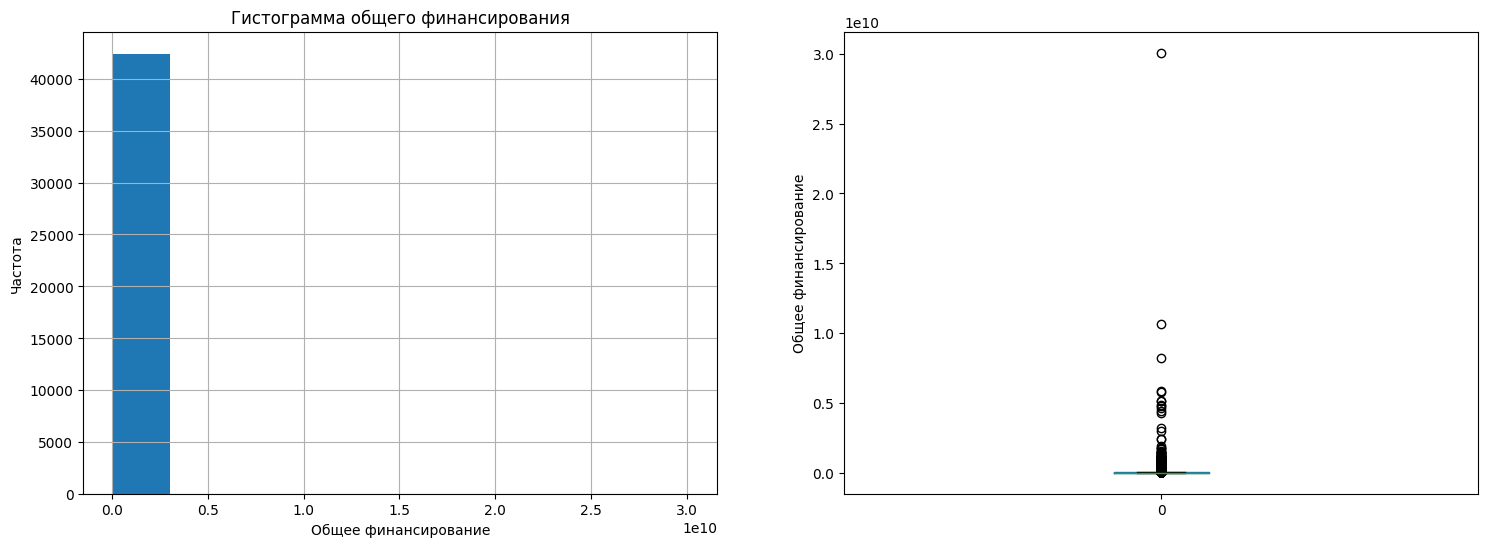

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

In [20]:
# Строим гистограмму для общего финансирования и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train[
    'funding_total_usd'].hist(figsize=(18, 6))
plt.title('Гистограмма общего финансирования')
plt.xlabel('Общее финансирование')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_total_usd'
].plot.box(use_index=False)
plt.ylabel('Общее финансирование')
plt.show()
startups_train[
    'funding_total_usd'
].describe()

In [21]:
# Считаем количество компаний с общим финансированием меньше 1000 долларов
print(
    'Количество компаний с общим финансированием меньше 1000 долларов -',
    startups_train[
        'funding_total_usd'
    ].loc[
        startups_train['funding_total_usd'] < 1000
    ].count()
)

Количество компаний с общим финансированием меньше 1000 долларов - 48


In [22]:
# Считаем количество компаний с общим финансированием больше 10.000.000 долларов
print(
    'Количество компаний с общим финансированием больше 10.000.000 долларов -',
    startups_train[
    'funding_total_usd'
    ].loc[
        startups_train['funding_total_usd'] > 100000000
    ].count()
)

Количество компаний с общим финансированием больше 10.000.000 долларов - 1238


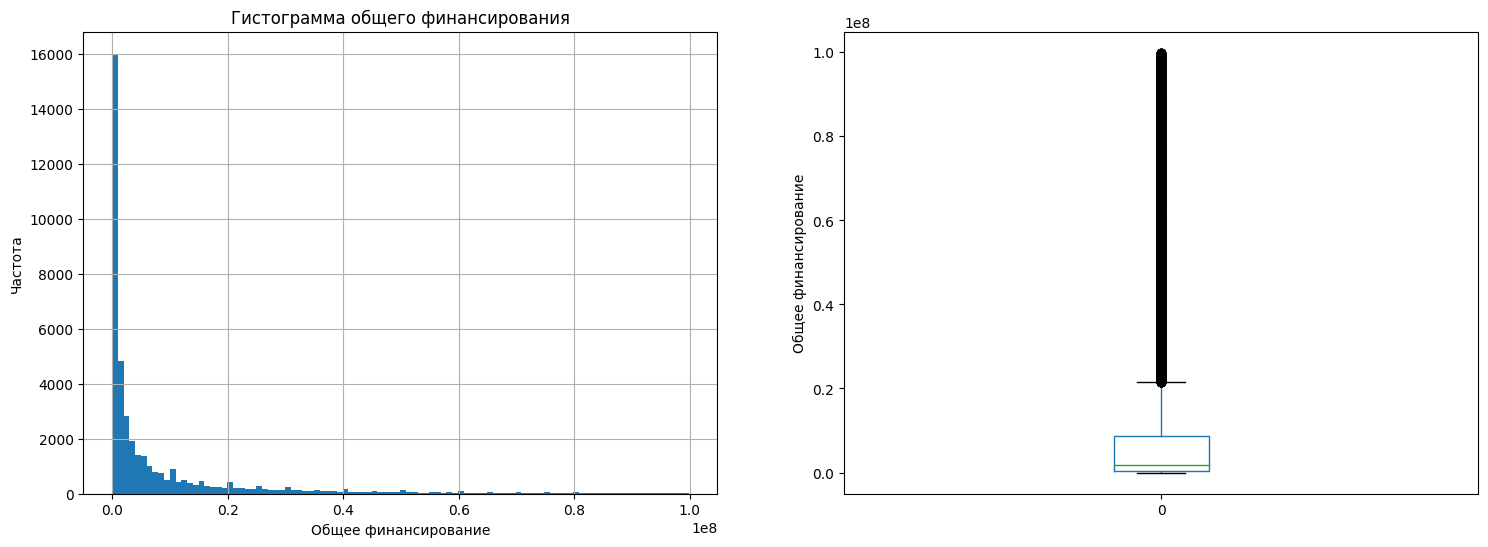

count    4.104500e+04
mean     8.661461e+06
std      1.604420e+07
min      1.050000e+03
25%      3.059920e+05
50%      1.844100e+06
75%      8.800000e+06
max      9.980000e+07
Name: funding_total_usd, dtype: float64

In [23]:
plt.subplot(1, 2, 1)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000)
].hist(bins=100, figsize=(18, 6))
plt.title('Гистограмма общего финансирования')
plt.xlabel('Общее финансирование')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000)
].plot.box(use_index=False)
plt.ylabel('Общее финансирование')
plt.show()
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000)
].describe()

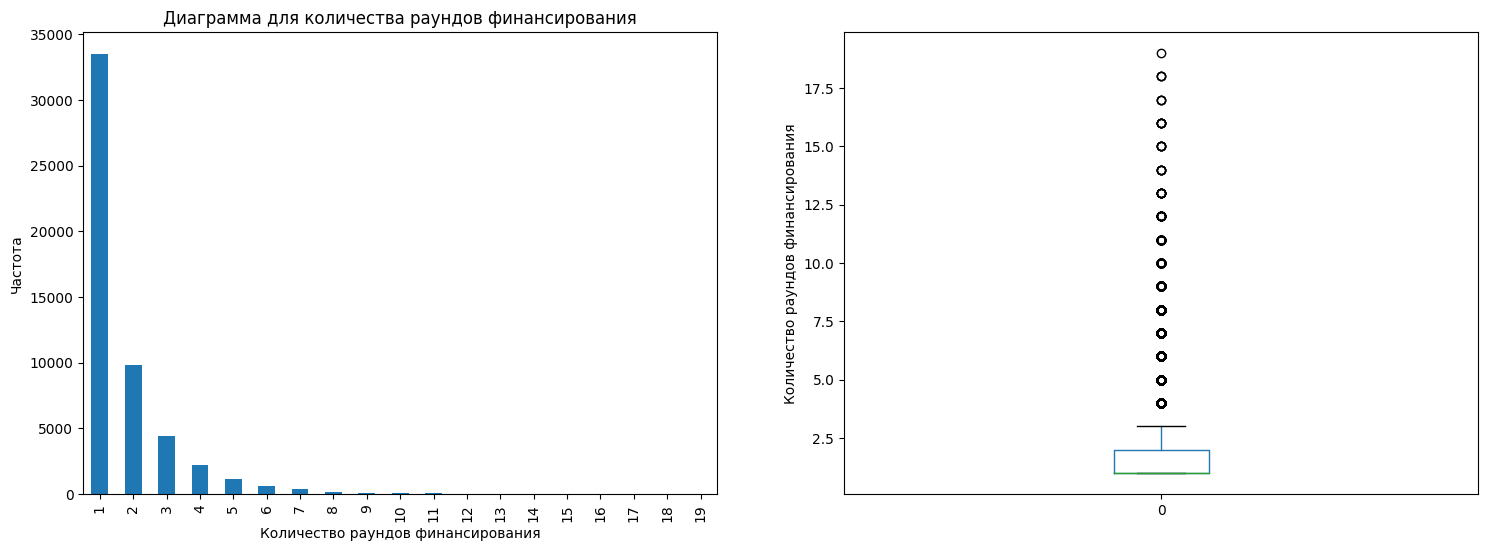

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

In [24]:
# Строим диаграмму для количества раундов финансирования и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
(
    startups_train.groupby(
        'funding_rounds'
    )[
        'funding_rounds'
    ].count().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title(
    'Диаграмма для количества раундов финансирования'
)
plt.xlabel('Количество раундов финансирования')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_rounds'
].plot.box(use_index=False)
plt.ylabel('Количество раундов финансирования')
plt.show()
startups_train[
    'funding_rounds'
].describe()

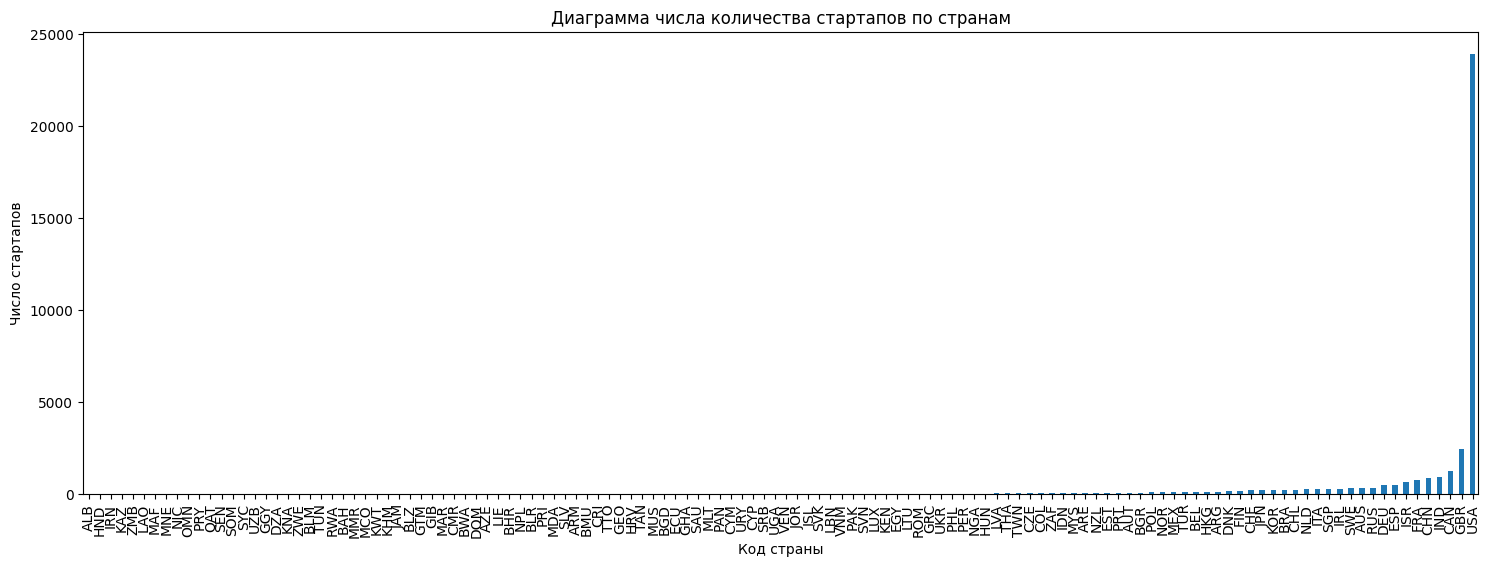

In [25]:
# Cтроим диаграмму для количества стартапов по странам
(
    startups_train.loc[
        (startups_train['funding_total_usd'] > 1000) &
        (startups_train['funding_total_usd'] < 100000000)
    ]
    .groupby('country_code')['country_code']
    .count().sort_values().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title('Диаграмма числа количества стартапов по странам')
plt.xlabel('Код страны')
plt.ylabel('Число стартапов')
plt.xticks(rotation=90)
plt.show()

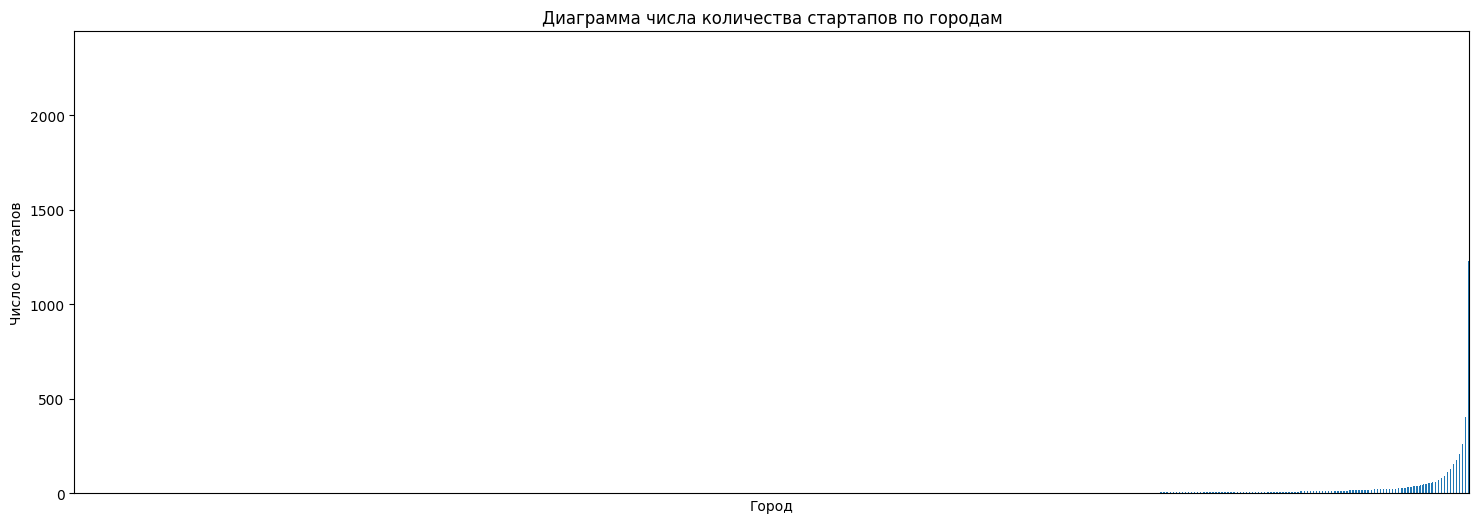

In [26]:
# Cтроим диаграмму для количества стартапов по городам
(
    startups_train.loc[
        (startups_train['funding_total_usd'] > 1000) &
        (startups_train['funding_total_usd'] < 100000000)
    ]
    .groupby('city')['city']
    .count().sort_values().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title('Диаграмма числа количества стартапов по городам')
plt.xlabel('Город')
plt.ylabel('Число стартапов')
plt.xticks([])
plt.show()